In [1]:
import rebound
%matplotlib inline
import matplotlib.pyplot as plt
import observations
import state
import mcmc
import numpy as np
import corner
from ipywidgets import FloatProgress
from IPython.display import display

# Setting up fake observations

In [2]:
true_state = state.State(planets=[{"m":1e-3, "a":0.22899774, "h":0.04, "k":0., "l":0.},{"m":2e-3, "a":0.30227013, "h":0.02, "k":0., "l":0.}])
obs = observations.FakeObservation(true_state, Npoints=100, error=0.00016786471, tmax=32.)

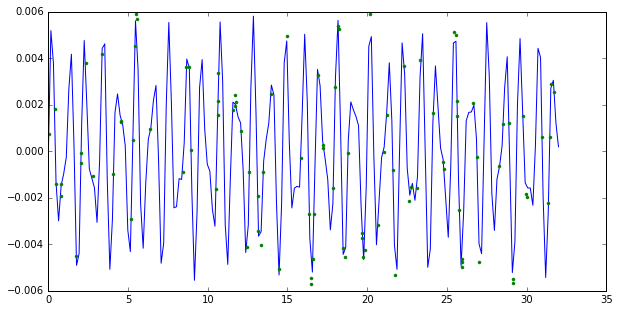

In [3]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.plot(*true_state.get_rv_plotting(tmax=32.))
ax.plot(obs.t, obs.rv, ".")

# SMALA 
Starting from exact solution.

In [ ]:
smala = mcmc.Smala(true_state,obs)
Niter = 2000
chain = np.zeros((Niter,smala.state.Nvars))
chainlogp = np.zeros(Niter)
tries = 0
f = FloatProgress(min=0, max=Niter)
display(f)
for i in range(Niter):
    tries += smala.step_force()
    chain[i] = smala.state.get_params()
    chainlogp[i] = smala.state.logp
    f.value = i
print("Acceptance rate: %.2f%%"%(float(Niter)/tries*100))

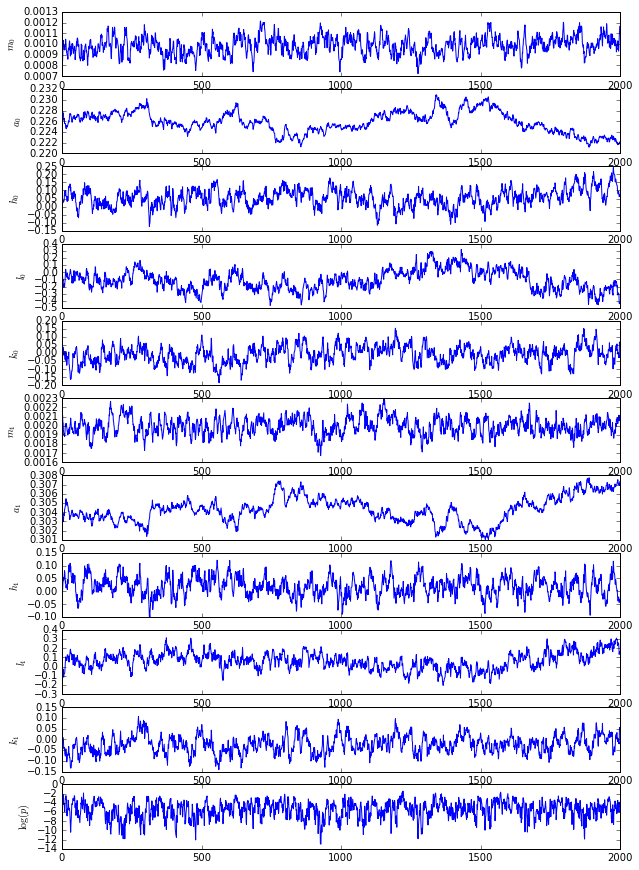

In [13]:
fig = plt.figure(figsize=(10,15))
for i in range(smala.state.Nvars):
    ax = plt.subplot(smala.state.Nvars+1,1,1+i)
    ax.set_ylabel(smala.state.get_keys()[i])
    ax.plot(chain[:,i])
ax = plt.subplot(smala.state.Nvars+1,1,smala.state.Nvars+1)
ax.set_ylabel("$\log(p)$")
ax.plot(chainlogp)    

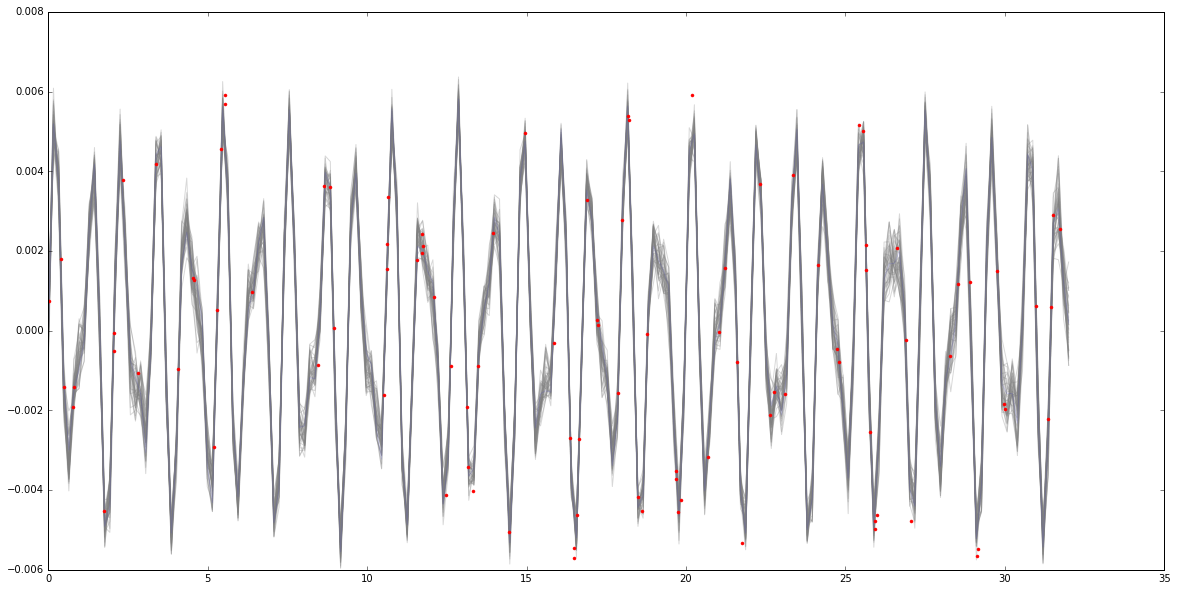

In [14]:
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(111)
for c in np.random.choice(Niter,40):
    s = smala.state.deepcopy()
    s.set_params(chain[c])
    ax.plot(*s.get_rv_plotting(tmax=32.), alpha=0.3, color="gray")
ax.plot(*true_state.get_rv_plotting(tmax=32.), alpha=0.1, color="blue")
ax.plot(obs.t, obs.rv, "r.")    

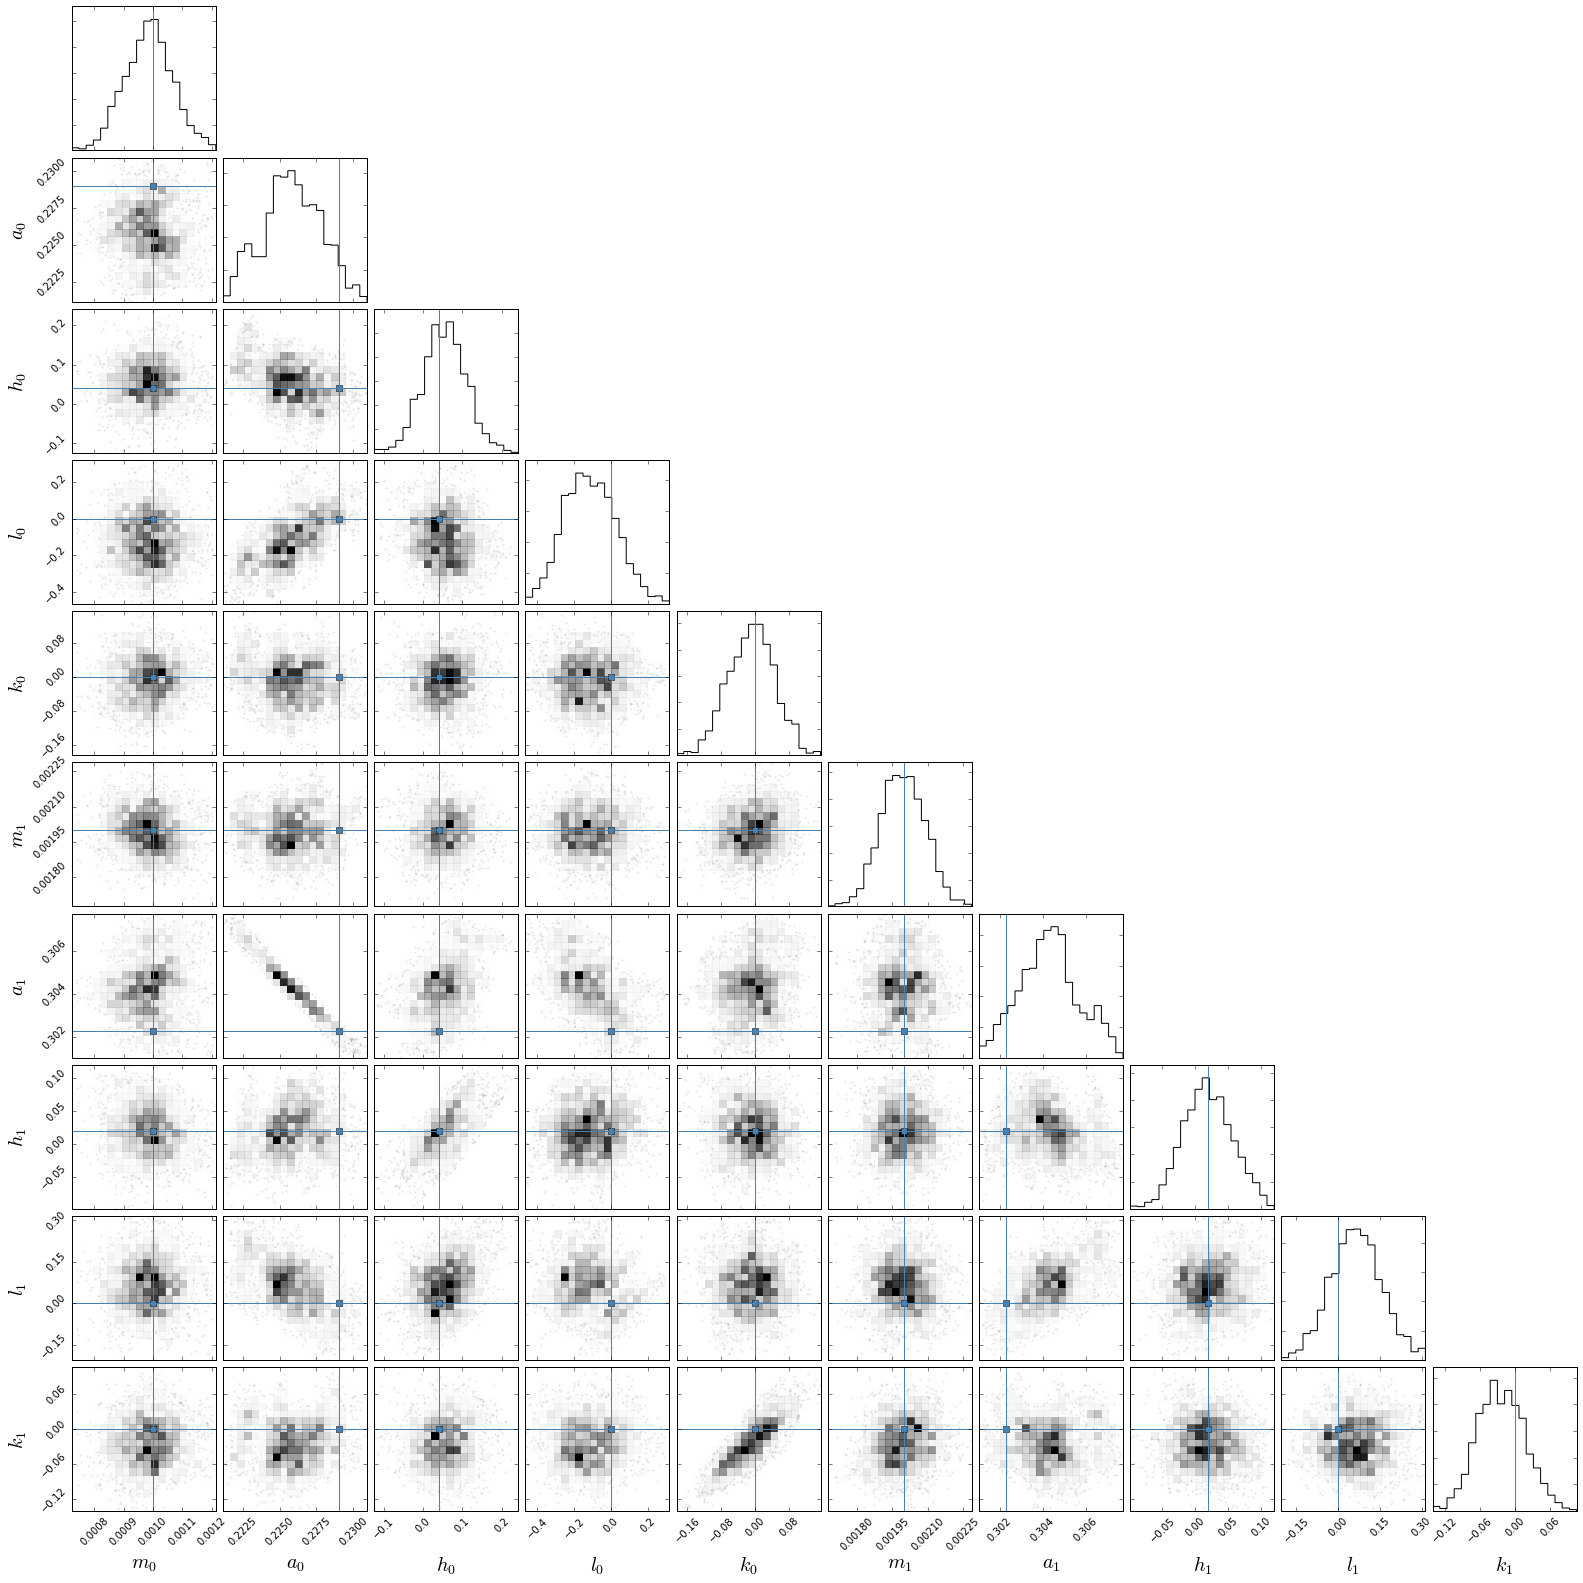

In [15]:
figure = corner.corner(chain, labels=s.get_keys(), plot_contours=False, truths=true_state.get_params(),label_kwargs={"fontsize":20})

In [16]:
def estimated_autocorrelation(x):
    """
    http://stackoverflow.com/q/14297012/190597
    http://en.wikipedia.org/wiki/Autocorrelation#Estimation
    """
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.correlate(x, x, mode = 'full')[-n:]
    assert np.allclose(r, np.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(n)]))
    result = r/(variance*(np.arange(n, 0, -1)))
    return result

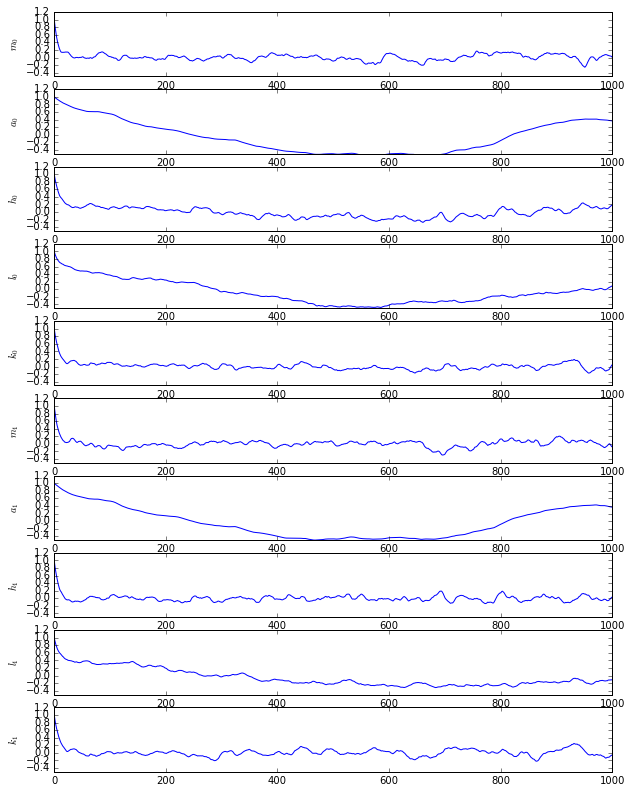

In [17]:
fig = plt.figure(figsize=(10,15))
for i in range(smala.state.Nvars):
    ax = plt.subplot(smala.state.Nvars+1,1,1+i)
    ax.set_ylim([-0.5,1.2])
    ax.set_xlim([0,Niter/2])
    ax.set_ylabel(smala.state.get_keys()[i])
    ac = estimated_autocorrelation(chain[:,i])
    ax.plot(ac)
#ax = plt.subplot(smala.state.Nvars+1,1,smala.state.Nvars+1)
#ax.set_ylabel("$\log(p)$")
#ax.plot(chainlogp)    